# Bases possíveis

In [1]:
import pandas as pd
import numpy as np

C:\Users\crisa\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df_mvp = pd.read_csv('Bases\\creditcard.csv')
df_mvp.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Métodos que serão analisados

# Pipeline padrão para Lightgbm

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import sklearn

In [5]:
import lightgbm

In [6]:
import skopt 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [8]:
from skopt import BayesSearchCV

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, LabelBinarizer, OrdinalEncoder, OneHotEncoder
from sklearn import set_config
from sklearn.model_selection import learning_curve, validation_curve
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

from lightgbm import early_stopping
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

In [9]:
from sklearn.impute import SimpleImputer

from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
import time

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
def splitxy(dataframe : pd.DataFrame, y : str = 'target'):
    X = dataframe.drop(labels = [y], axis = 1)
    y = dataframe[y]
    
    return(X, y)


def train_test_val(X: pd.DataFrame, y: pd.Series):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42, stratify = y_train)
    
    return(X_train, y_train, X_test, y_test, X_val, y_val)


def create_prep_pipe(dataframe : pd.DataFrame, target_column : str) -> (sklearn.pipeline.FeatureUnion, pd.Series, pd.Series):
    dataframe = dataframe.drop(labels = [target_column], axis = 1)
    num_cols = dataframe.select_dtypes(include=[float, int]).columns
    cat_cols = dataframe.select_dtypes(include=[object, pd.datetime]).columns
    
    if num_cols.values.shape[0] > 0:
        pipe_num = Pipeline(
        steps = [
            ("selector_num", ColumnTransformer([("selector", "passthrough", num_cols.values)], remainder = 'drop')),
            ('num_imputer', SimpleImputer(strategy='mean'))
        ])
    else:
        pipe_num = None
        
    if cat_cols.values.shape[0] > 0:
        pipe_cat = Pipeline(
        steps = [
            ("selector_cat", ColumnTransformer([("selector", "passthrough", cat_cols.values)], remainder = 'drop')),
            ("OrdinalEnc", OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)),
            ('cat_imputer', SimpleImputer(strategy='constant', fill_value='None'))
        ])        
    else:
        pipe_cat = None
       
    if pipe_num is not None and pipe_cat is not None:
        prep_feat = FeatureUnion(
        transformer_list = [
            ('num_pipe', pipe_num),
            ('cat_pipe', pipe_cat)
            
        ], verbose = False)  
        
        return (prep_feat, num_cols.values, cat_cols.values)

    if pipe_num is not None and pipe_cat is None:
        prep_feat = FeatureUnion(
        transformer_list = [
            ('num_pipe', pipe_num)
            
        ], verbose = False)
        
        return (prep_feat, num_cols.values, [])

    if pipe_num is None and pipe_cat is not None:
        prep_feat = FeatureUnion(
        transformer_list = [
            ('cat_pipe', pipe_cat)
            
        ], verbose = False) 
        
        return (prep_feat, [], cat_cols.values)


def plot_dist(y_train, pred_proba_train, y_val, pred_proba_val):
    
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
    plt.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.2, hspace = 0.4)
    
    vis = pd.DataFrame()
    vis['target'] = y_train
    vis['proba'] = pred_proba_train
    
    list_1 = vis[vis.target == 1].proba
    list_2 = vis[vis.target == 0].proba
    
    sns.distplot(list_1, kde = True, ax = axs[0], hist = True, bins = 100)
    sns.distplot(list_2, kde = True, ax = axs[0], hist = True, bins = 100)
    
    axs[0].set_title('train Thereshold Curve')
    
    
    
    vis = pd.DataFrame()
    vis['target'] = y_val
    vis['proba'] = pred_proba_val
    
    list_1 = vis[vis.target == 1].proba
    list_2 = vis[vis.target == 0].proba
    
    sns.distplot(list_1, kde = True, ax = axs[1], hist = True, bins = 100)
    sns.distplot(list_2, kde = True, ax = axs[1], hist = True, bins = 100)
    
    axs[1].set_title('valid Thereshold Curve')    

In [12]:
class tcc_lgbm():
    def __init__(self, dataframe : pd.DataFrame, target: str, metric : str = 'average_precision', pipe_final : sklearn.pipeline = None):
        self.dataframe = dataframe
        self.target = target
        self.metric = metric
        self._pipe_final = pipe_final
    
    def fit(self):
        X, y = splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = train_test_val(X,y)
    
        prep_feat_tuple = create_prep_pipe(self.dataframe, self.target)
        prep_feat = prep_feat_tuple[0]
    
        lists_pandarizer = list(prep_feat_tuple[1]) + list(prep_feat_tuple[2])
        
        LGBM = LGBMClassifier(random_state = 42, n_jobs = -1)

        pipe_tuning = Pipeline([
            ('transformer_prep', prep_feat),
            ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = lists_pandarizer))),
            ('estimator', LGBM)
        ])
        
        pipe_prep = Pipeline([
            ('transformer_prep', prep_feat),
            ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = lists_pandarizer))),
        ])
        pipe_prep.fit(X_train)       
        
        cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 42)
        
        metric = self.metric
        
        fit_params = {
            'eval_metric': metric, 
            'eval_set': [(X_test, pd.DataFrame(y_test))],
            'callbacks': [(early_stopping(stopping_rounds = 10, verbose = True))],
        }        
        
        LGBM_search_space = {
            "estimator__learning_rate": Real(0.001, 0.01, prior = 'log-uniform'),
            "estimator__n_estimators": Integer(100, 1000),
            "estimator__class_weight": Categorical(['balanced', None]),
            "estimator__num_leaves": Integer(32, 256),
            "estimator__min_child_samples": Integer(100, 1000),
            "estimator__reg_alpha": Real(0, 100, prior = 'uniform'),
            "estimator__reg_lambda": Real(10., 200., prior = 'uniform'),
            "estimator__objective": Categorical(['binary']),
            "estimator__importance_type":Categorical(['gain']),
            "estimator__boosting_type": Categorical(['goss'])
        }    
        
        LGBM_bayes_search = BayesSearchCV(pipe_tuning, LGBM_search_space, n_iter = 2, scoring = metric, 
                                         return_train_score = True, 
                                         fit_params = fit_params,
                                         n_jobs = -1, cv = cv, random_state = 42, optimizer_kwargs = {'base_estimator': 'GP'})
        
        
        LGBM_bayes_search.fit(X_train, y_train)        
        
        results_cv = pd.DataFrame(LGBM_bayes_search.cv_results_)
        
        temp = results_cv[['mean_train_score', 'mean_test_score']]
        temp['diff'] = temp['mean_test_score'] - temp['mean_train_score']
        to_go = temp[abs(temp['diff']) < 0.05].sort_values(by = 'mean_test_score', ascending = False).head(1).index
        
        params = results_cv.loc[to_go.values[0]]
        kwargs = params.params   
        print(kwargs)
        
        best_LGBM = LGBMClassifier(random_state = 42, n_jobs = -1, verbose = -1, **kwargs)
        
        best_LGBM.fit(pipe_prep.transform(X_train), y_train, early_stopping_rounds = 10, verbose = 20, eval_metric = metric,
                     eval_set = [(pipe_prep.transform(X_test), y_test)]) 
        
        
        pipe_final = Pipeline(
        [
            ('pipe_transformer_prep', pipe_prep),
            ('pipe_estimator', best_LGBM)
        ])       
        
        self._pipe_final = pipe_final
        
    def predict_proba(self, who : str = 'val'):
        if self._pipe_final is None:
            return None
        
        X, y = splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = train_test_val(X,y)        
        
        dic = {'val': X_val, 
              'test': X_test,
              'train': X_train}
        y_score = self._pipe_final.predict_proba(dic[who])[:,1]
        return y_score
    
    def get_metric(self, who : str = 'val'):
        if self._pipe_final is None:
            return None
        
        X, y = splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = train_test_val(X,y)
        
        dic_x = {'val': X_val, 
              'test': X_test,
              'train': X_train}

        dic_y = {'val': y_val, 
              'test': y_test,
              'train': y_train}
        
        
        y_score = self._pipe_final.predict_proba(dic_x[who])[:,1]
        average_precision = average_precision_score(dic_y[who], y_score)
        return average_precision
    
    
    def plot_dist(self):
        if self._pipe_final is None:
            return None        

        X, y = splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = train_test_val(X,y)        
        
        y_score_train = self._pipe_final.predict_proba(X_train)[:,1]
        y_score_val = self._pipe_final.predict_proba(X_val)[:,1]
        
        plot_dist(y_train, y_score_train, y_val, y_score_val)
        

In [13]:
temp_lgbm = tcc_lgbm(df_mvp, 'Class')

In [14]:
temp_lgbm.fit()

OrderedDict([('estimator__boosting_type', 'goss'), ('estimator__class_weight', None), ('estimator__importance_type', 'gain'), ('estimator__learning_rate', 0.002069186296126171), ('estimator__min_child_samples', 703), ('estimator__n_estimators', 473), ('estimator__num_leaves', 111), ('estimator__objective', 'binary'), ('estimator__reg_alpha', 30.44633110365062), ('estimator__reg_lambda', 133.08040178590676)])


In [15]:
temp_lgbm._pipe_final

Pipeline(steps=[('pipe_transformer_prep',
                 Pipeline(steps=[('transformer_prep',
                                  FeatureUnion(transformer_list=[('num_pipe',
                                                                  Pipeline(steps=[('selector_num',
                                                                                   ColumnTransformer(transformers=[('selector',
                                                                                                                    'passthrough',
                                                                                                                    array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V2...
                 LGBMClassifier(estimator__boosting_type='goss',
                                estimator__class_weight=None,
                                estimator__importance_type='gain',
                                estimator__learning_rate=0.002069186296126171,
                                estimator__min_child_samples=703,
                                estimator__n_estimators=473,
                                estimator__num_leaves=111,
                                estimator__objective='binary',
                                estimator__reg_alpha=30.44633110365062,
                                estimator__reg_lambda=133.08040178590676,
                                random_state=42, verbose=-1))])

In [16]:
temp_lgbm.predict_proba(who = 'val')

array([0.00157184, 0.00157184, 0.00157675, ..., 0.00157184, 0.00157184,
       0.00157184])

In [17]:
[temp_lgbm.get_metric(who = 'train'), temp_lgbm.get_metric(who = 'test'), temp_lgbm.get_metric(who = 'val')]

[0.8712203126285343, 0.7368724168176575, 0.773486477188228]

In [18]:
temp_lgbm.get_metric(who = 'train') - temp_lgbm.get_metric(who = 'val')

0.09773383544030623

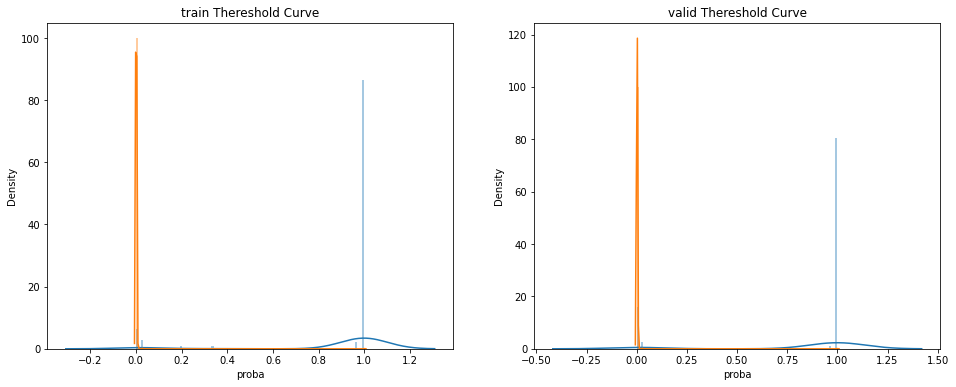

In [19]:
temp_lgbm.plot_dist()

# Pipeline Padrão para SMOTE

In [20]:
import warnings
warnings.filterwarnings('ignore')
import sklearn

In [21]:
import skopt 

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [23]:
from skopt import BayesSearchCV

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, LabelBinarizer, OrdinalEncoder, OneHotEncoder
from sklearn import set_config
from sklearn.model_selection import learning_curve, validation_curve
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

from lightgbm import early_stopping
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

In [24]:
from sklearn.impute import SimpleImputer

from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
import time

In [25]:
from imblearn.over_sampling import SMOTE

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
def splitxy(dataframe : pd.DataFrame, y : str = 'target'):
    X = dataframe.drop(labels = [y], axis = 1)
    y = dataframe[y]
    
    return(X, y)


def train_test_val(X: pd.DataFrame, y: pd.Series):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42, stratify = y_train)
    
    return(X_train, y_train, X_test, y_test, X_val, y_val)


def create_prep_pipe(dataframe : pd.DataFrame, target_column : str) -> (sklearn.pipeline.FeatureUnion, pd.Series, pd.Series):
    dataframe = dataframe.drop(labels = [target_column], axis = 1)
    num_cols = dataframe.select_dtypes(include=[float, int]).columns
    cat_cols = dataframe.select_dtypes(include=[object, pd.datetime]).columns
    
    if num_cols.values.shape[0] > 0:
        pipe_num = Pipeline(
        steps = [
            ("selector_num", ColumnTransformer([("selector", "passthrough", num_cols.values)], remainder = 'drop')),
            ('num_imputer', SimpleImputer(strategy='mean'))
        ])
    else:
        pipe_num = None
        
    if cat_cols.values.shape[0] > 0:
        pipe_cat = Pipeline(
        steps = [
            ("selector_cat", ColumnTransformer([("selector", "passthrough", cat_cols.values)], remainder = 'drop')),
            ("OrdinalEnc", OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)),
            ('cat_imputer', SimpleImputer(strategy='constant', fill_value='None'))
        ])        
    else:
        pipe_cat = None
       
    if pipe_num is not None and pipe_cat is not None:
        prep_feat = FeatureUnion(
        transformer_list = [
            ('num_pipe', pipe_num),
            ('cat_pipe', pipe_cat)
            
        ], verbose = False)  
        
        return (prep_feat, num_cols.values, cat_cols.values)

    if pipe_num is not None and pipe_cat is None:
        prep_feat = FeatureUnion(
        transformer_list = [
            ('num_pipe', pipe_num)
            
        ], verbose = False)
        
        return (prep_feat, num_cols.values, [])

    if pipe_num is None and pipe_cat is not None:
        prep_feat = FeatureUnion(
        transformer_list = [
            ('cat_pipe', pipe_cat)
            
        ], verbose = False) 
        
        return (prep_feat, [], cat_cols.values)


def plot_dist(y_train, pred_proba_train, y_val, pred_proba_val):
    
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
    plt.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.2, hspace = 0.4)
    
    vis = pd.DataFrame()
    vis['target'] = y_train
    vis['proba'] = pred_proba_train
    
    list_1 = vis[vis.target == 1].proba
    list_2 = vis[vis.target == 0].proba
    
    sns.distplot(list_1, kde = True, ax = axs[0], hist = True, bins = 100)
    sns.distplot(list_2, kde = True, ax = axs[0], hist = True, bins = 100)
    
    axs[0].set_title('train Thereshold Curve')
    
    
    
    vis = pd.DataFrame()
    vis['target'] = y_val
    vis['proba'] = pred_proba_val
    
    list_1 = vis[vis.target == 1].proba
    list_2 = vis[vis.target == 0].proba
    
    sns.distplot(list_1, kde = True, ax = axs[1], hist = True, bins = 100)
    sns.distplot(list_2, kde = True, ax = axs[1], hist = True, bins = 100)
    
    axs[1].set_title('valid Thereshold Curve')    

In [28]:
class tcc_smote():
    def __init__(self, dataframe : pd.DataFrame, target: str, metric : str = 'average_precision', pipe_final : sklearn.pipeline = None):
        self.dataframe = dataframe
        self.target = target
        self.metric = metric
        self._pipe_final = pipe_final
    
    def fit(self):
        X, y = splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = train_test_val(X,y)
    
        prep_feat_tuple = create_prep_pipe(self.dataframe, self.target)
        prep_feat = prep_feat_tuple[0]
    
        lists_pandarizer = list(prep_feat_tuple[1]) + list(prep_feat_tuple[2])
        
        LGBM = LGBMClassifier(random_state = 42, n_jobs = -1)
  
        pipe_prep = Pipeline([
            ('transformer_prep', prep_feat),
            ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = lists_pandarizer))),
        ])
        pipe_prep.fit(X_train)       
     

        metric = self.metric
        
        RF_estimator = RandomForestClassifier(random_state= 42)
        
        smote = SMOTE()
        X_train_smote, y_train_smote = smote.fit_resample(pipe_prep.transform(X_train), y_train)
        RF_estimator.fit(X_train_smote, y_train_smote) 
        
        
        pipe_final = Pipeline(
        [
            ('pipe_transformer_prep', pipe_prep),
            ('pipe_estimator', RF_estimator)
        ])       
        
        self._pipe_final = pipe_final
        
    def predict_proba(self, who : str = 'val'):
        if self._pipe_final is None:
            return None
        
        X, y = splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = train_test_val(X,y)        
        
        dic = {'val': X_val, 
              'test': X_test,
              'train': X_train}
        y_score = self._pipe_final.predict_proba(dic[who])[:,1]
        return y_score
    
    def get_metric(self, who : str = 'val'):
        if self._pipe_final is None:
            return None
        
        X, y = splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = train_test_val(X,y)
        
        dic_x = {'val': X_val, 
              'test': X_test,
              'train': X_train}

        dic_y = {'val': y_val, 
              'test': y_test,
              'train': y_train}
        
        
        y_score = self._pipe_final.predict_proba(dic_x[who])[:,1]
        average_precision = average_precision_score(dic_y[who], y_score)
        return average_precision
    
    
    def plot_dist(self):
        if self._pipe_final is None:
            return None        

        X, y = splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = train_test_val(X,y)        
        
        y_score_train = self._pipe_final.predict_proba(X_train)[:,1]
        y_score_val = self._pipe_final.predict_proba(X_val)[:,1]
        
        plot_dist(y_train, y_score_train, y_val, y_score_val)


In [29]:
temp_smote = tcc_smote(df_mvp, 'Class')

In [ ]:
temp_smote.fit()

In [ ]:
temp_smote._pipe_final

In [ ]:
temp_smote.predict_proba(who = 'val')

In [ ]:
[temp_smote.get_metric(who = 'train'), temp_smote.get_metric(who = 'test'), temp_smote.get_metric(who = 'val')]

In [ ]:
temp_smote.get_metric(who = 'train') - temp_smote.get_metric(who = 'val')

In [ ]:
temp_smote.plot_dist()

# HDDT Ensemble

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from math import sqrt
import operator


class HDDT(BaseEstimator, ClassifierMixin):
    """
    HDDT (Hellinger Distance Decision Tree).
    References
    ----------
    ..[1]   David A. Cieslak, T. Ryan Hoens, Nitesh V. Chawla and W. Philip Kegelmeyer, Data Min Knowl Disc 2011
            https://www3.nd.edu/~dial/papers/DMKD11.pdf
    ..[2]   Learning Decision Trees for Unbalanced Data, David A. Cieslak and Nitesh V. Chawla, ECML 2008
            https://www3.nd.edu/~dial/papers/ECML08.pdf
    ..[3]   Implementation of the HDDT in R programming language
            https://github.com/kaurao/HDDT
    """

    def __init__(self, C=9):
        # TODO: grid search - for the best C
        # C=2 - for all
        # C=9 - for real streams
        self.C = C

    def fit(self, X, y):
        """Fitting."""
        self.partial_fit(X, y)
        return self

    def partial_fit(self, X, y, classes=None):
        if type(y) is not np.ndarray:
            y = np.array(y)
        # Check classes
        self.classes_ = classes
        if self.classes_ is None:
            self.classes_, _ = np.unique(y, return_inverse=True)

        self.labels = np.unique(y)

        # Check if is continuous or discrete
        self.n_features = X.shape[1]
        self.features_type = []
        for f in range(self.n_features):
            if isinstance(X[0,f], float):
                self.features_type.append("continuous")
            else:
                self.features_type.append("discrete")

        self.root = self.HDDT_func(X, y, self.C)

        return self

    def predict(self, X):
        n_row = X.shape[0]
        y = np.full(n_row, -1)
        for i in range(n_row):
            # search the tree until we find a leaf node
            node = self.root
            while isinstance(node.get("v"), (int, float)):
                if node["type"] == "discrete":
                    if X[i,node["i"]] == node["v"]:
                        node = node["childLeft"]
                    else:
                        node = node["childRight"]

                elif node["type"] == "continuous":
                    if X[i,node["i"]] <= node["v"]:
                        node = node["childLeft"]
                    else:
                        node = node["childRight"]
            y[i] = node["label"]
        # Return prediction classes, for example 0 or 1
        return y

    def predict_proba(self, X):
        n_row = X.shape[0]
        probas = np.full((n_row,2), -1)
        for i in range(n_row):
            # search the tree until we find a leaf node
            node = self.root
            while isinstance(node.get("v"), (int, float)):
                if node["type"] == "discrete":
                    if X[i,node["i"]] == node["v"]:
                        node = node["childLeft"]
                    else:
                        node = node["childRight"]

                elif node["type"] == "continuous":
                    if X[i,node["i"]] <= node["v"]:
                        node = node["childLeft"]
                    else:
                        node = node["childRight"]
            probas[i][0] = node["proba"][0]
            probas[i][1] = node["proba"][1]
        # Return prediction probabilities of occurrence class 0 or 1, for example 0,238 and 0,762
        return probas

    def HDDT_func(self, X, y, C):
        """
        HDDT function to create and use Hellinger distance decision tree (HDDT). It is a recursive function that calls itself with subsets of training data that matches the decision criterion using a list to create the tree structure.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples, )
            Classes/labels
        C : integer
            Minimum size of the training set at a node to attempt a split. Size of cut-off.
        labels : array-like, optional
            The default is None.
        Returns
        -------
        node : tuple
            The root node of the deicison tree
        """

        # Node of the tree. When called for the first time, this will be the root
        node = {}
        node["C"] = C
        node["labels"] = self.labels

        # If there is only one class, this is leaf
        if len(np.unique(y)) == 1:
            node["label"] = y[0]
            if y[0] == 0:
                node["proba"] = [1, 0]
            else:
                node["proba"] = [0, 1]
            return node

        # If y is smaller than minimum size of the training set, this is leaf
        elif len(y) < C:
            # Count number of samples of every class
            classes, counts = np.unique(y, return_counts=True)

            # Use Laplace smoothing, by adding 1 to count of each class
            counts[0] += 1
            counts[1] += 1

            # Count probabilities of every class
            p = counts[0] / len(y)
            if classes[0] == 0:
                node["proba"] = [p, 1-p]
            else:
                node["proba"] = [1-p, p]

            # Return label of that class(0 or 1), where there is more samples
            if counts[0] > counts[1]:
                node["label"] = classes[0]
            else:
                node["label"] = classes[1]
            return node

        # this is node
        else:
            # HD is 2D-array, it contains Hellinger Distance, value (place of split) and type (discrete or continuous)
            HD = []
            # hd contains only Hellinger Distance
            hd = []
            # Use function HDDT_dist in a recursive way
            for i in range(self.n_features):
                hel_dist = self.HDDT_dist(X[:,i], y, self.features_type[i])
                HD.append(hel_dist)
                hd.append(hel_dist[0])

            i  = np.argmax(hd)

            # Save node attributes
            node["i"] = i       # feature
            node["d"] = HD[i][0]
            node["v"] = HD[i][1]
            node["type"] = HD[i][2]

            if node["type"] == "discrete":
                # j contains True and False values, True is when sample in X is equal v
                j = np.array((X[:,i] == node["v"]))
                node["childLeft"] = self.HDDT_func(X[j,:], y[j], C)
                opposite_j = [operator.not_(value_j) for value_j in j]
                node["childRight"] = self.HDDT_func(X[opposite_j,:], y[opposite_j], C)

            elif node["type"] == "continuous":
                # j contains True and False values, True is when sample in X is lower or equal v
                j = np.array((X[:,i] <= node["v"]))
                node["childLeft"] = self.HDDT_func(X[j,:], y[j], C)
                opposite_j = [operator.not_(value_j) for value_j in j]
                node["childRight"] = self.HDDT_func(X[opposite_j,:], y[opposite_j], C)

        return node

    def HDDT_dist(self, f, y, f_type):

        """
        Calculate Hellinger distance for a given feature vector.
        Attributes can be discrete or continuous.
        It returns Hellinger distance, "value" of the feature that is used as decision criterion (splitting) and type of feature (discrete or continuous).
        It works ONLY for binary labels.
        """

        # Count number of samples of every class
        classes, counts = np.unique(y, return_counts=True)

        hellinger = -1
        # Number of samples for each class
        T0 = counts[0]
        T1 = counts[1]
        val = 0

        cl = f_type

        # Check if the feature is discrete or continuous
        if cl == "discrete":
            for v in np.unique(f):

                # Number of class 0 and class1 of value v in f (features)
                v_index = np.argwhere(f==v).ravel()
                Tfv1 = len(np.argwhere(y[v_index]==classes[1]).ravel())
                Tfv0 = len(np.argwhere(y[v_index]==classes[0]).ravel())

                Tfw1 = T1 - Tfv1
                Tfw0 = T0 - Tfv0

                # Calculate Hellinger distance
                cur_value = (sqrt(Tfv1/T1) - sqrt(Tfv0/T0))**2 + (sqrt(Tfw1/T1) - sqrt(Tfw0/T0))**2

                if cur_value > hellinger:
                    hellinger = cur_value
                    val = v

        elif cl == "continuous":
            for v in np.unique(f):
                v_index = np.argwhere(f<=v).ravel()
                Tfv1 = len(np.argwhere(y[v_index]==classes[1]).ravel())
                Tfv0 = len(np.argwhere(y[v_index]==classes[0]).ravel())
                Tfw1 = T1 - Tfv1
                Tfw0 = T0 - Tfv0

                # Calculate Hellinger distance
                cur_value = (sqrt(Tfv1/T1) - sqrt(Tfv0/T0))**2 + (sqrt(Tfw1/T1) - sqrt(Tfw0/T0))**2

                if cur_value > hellinger:
                    hellinger = cur_value
                    val = v
        # return 3 values in tuple (Hellinger distance, value of split, type of the feature)
        return (sqrt(hellinger), val, cl)

# EasyEmsemble

In [ ]:
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
import collections

In [ ]:
class tcc_easyemsemble():
    def __init__(self, dataframe : pd.DataFrame, target: str, metric : str = 'average_precision', pipe_final : sklearn.pipeline = None):
        self.dataframe = dataframe
        self.target = target
        self.metric = metric
        self._pipe_final = pipe_final
    
    def fit(self):
        X, y = splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = train_test_val(X,y)
    
        prep_feat_tuple = create_prep_pipe(self.dataframe, self.target)
        prep_feat = prep_feat_tuple[0]
    
        lists_pandarizer = list(prep_feat_tuple[1]) + list(prep_feat_tuple[2])
        
        pipe_prep = Pipeline([
            ('transformer_prep', prep_feat),
            ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = lists_pandarizer))),
        ])
        pipe_prep.fit(X_train)       
        
        cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 42)
        
        metric = self.metric
        
        ## AdaBoost

        ADA = AdaBoostClassifier(random_state = 42)

        pipe_tuning = Pipeline([
            ('transformer_prep', prep_feat),
            ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = lists_pandarizer))),
            ('estimator', ADA)
        ])        
        
        fit_params = {
            'eval_metric': metric, 
            'eval_set': [(X_test, pd.DataFrame(y_test))],
            'callbacks': [(early_stopping(stopping_rounds = 10, verbose = True))],
        }        
        
        ADA_search_space = {
            "estimator__n_estimators": Integer(100, 1000),   
            "estimator__learning_rate": Real(0.001, 0.01, prior = 'log-uniform'),
            "estimator__algorithm": Categorical(['SAMME', 'SAMME.R'])
      }    
        
        ADA_bayes_search = BayesSearchCV(pipe_tuning, ADA_search_space, n_iter = 2, scoring = metric, 
                                         return_train_score = True, 
                                         fit_params = fit_params,
                                         n_jobs = -1, cv = cv, random_state = 42, optimizer_kwargs = {'base_estimator': 'GP'})
        
        
        ADA_bayes_search.fit(X_train, y_train)        
        
        results_cv = pd.DataFrame(ADA_bayes_search.cv_results_)
        
        temp = results_cv[['mean_train_score', 'mean_test_score']]
        temp['diff'] = temp['mean_test_score'] - temp['mean_train_score']
        to_go = temp[abs(temp['diff']) < 0.2].sort_values(by = 'mean_test_score', ascending = False).head(1).index
        
        params = results_cv.loc[to_go.values[0]]
        kwargs = params.params   
        kwargs = collections.OrderedDict((key.replace('estimator__', ''), value) for key, value in kwargs.items())
        print(kwargs)
        
        best_ADA = AdaBoostClassifier(random_state = 42, **kwargs)
        
        ## EasyEmsemble 

        
        EASY = EasyEnsembleClassifier(random_state = 42, base_estimator = best_ADA)

        pipe_tuning = Pipeline([
            ('transformer_prep', prep_feat),
            ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = lists_pandarizer))),
            ('estimator', EASY)
        ])
        
        
        fit_params = {
            'eval_metric': metric, 
            'eval_set': [(X_test, pd.DataFrame(y_test))],
            'callbacks': [(early_stopping(stopping_rounds = 10, verbose = True))],
        }        
        
        EASY_search_space = {
            "estimator__n_estimators": Integer(100, 1000),
            "estimator__warm_start": Categorical([True, False]),
            "estimator__sampling_strategy": Categorical(['majority', 'all']),
            "estimator__replacement": Categorical([True, False])
        }    
        
        print('chegamos aqui')
        EASY_bayes_search = BayesSearchCV(pipe_tuning, EASY_search_space, n_iter = 2, scoring = metric, 
                                         return_train_score = True, 
                                         fit_params = fit_params,
                                         n_jobs = -1, cv = cv, random_state = 42, optimizer_kwargs = {'base_estimator': 'GP'})
        
        
        EASY_bayes_search.fit(X_train, y_train)        
        
        results_cv = pd.DataFrame(EASY_bayes_search.cv_results_)
        
        temp = results_cv[['mean_train_score', 'mean_test_score']]
        temp['diff'] = temp['mean_test_score'] - temp['mean_train_score']
        to_go = temp[abs(temp['diff']) < 0.2].sort_values(by = 'mean_test_score', ascending = False).head(1).index
        
        params = results_cv.loc[to_go.values[0]]
        kwargs = params.params   
        kwargs = collections.OrderedDict((key.replace('estimator__', ''), value) for key, value in kwargs.items())
        print(kwargs)
        
        best_EASY = EasyEnsembleClassifier(random_state = 42,  base_estimator = best_ADA,  **kwargs)
        
        best_EASY.fit(pipe_prep.transform(X_train), y_train) 
        
        
        pipe_final = Pipeline(
        [
            ('pipe_transformer_prep', pipe_prep),
            ('pipe_estimator', best_EASY)
        ])       
        
        self._pipe_final = pipe_final
        
    def predict_proba(self, who : str = 'val'):
        if self._pipe_final is None:
            return None
        
        X, y = splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = train_test_val(X,y)        
        
        dic = {'val': X_val, 
              'test': X_test,
              'train': X_train}
        y_score = self._pipe_final.predict_proba(dic[who])[:,1]
        return y_score
    
    def get_metric(self, who : str = 'val'):
        if self._pipe_final is None:
            return None
        
        X, y = splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = train_test_val(X,y)
        
        dic_x = {'val': X_val, 
              'test': X_test,
              'train': X_train}

        dic_y = {'val': y_val, 
              'test': y_test,
              'train': y_train}
        
        
        y_score = self._pipe_final.predict_proba(dic_x[who])[:,1]
        average_precision = average_precision_score(dic_y[who], y_score)
        return average_precision
    
    
    def plot_dist(self):
        if self._pipe_final is None:
            return None        

        X, y = splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = train_test_val(X,y)        
        
        y_score_train = self._pipe_final.predict_proba(X_train)[:,1]
        y_score_val = self._pipe_final.predict_proba(X_val)[:,1]
        
        plot_dist(y_train, y_score_train, y_val, y_score_val)
        

In [ ]:
df_mvp.shape

In [ ]:
temp_easy = tcc_easyemsemble(df_mvp.head(8000), 'Class')

In [ ]:
temp_easy.fit()

In [ ]:
temp_easy._pipe_final

In [ ]:
temp_easy.predict_proba(who = 'val')

In [ ]:
[temp_easy.get_metric(who = 'train'), temp_easy.get_metric(who = 'test'), temp_easy.get_metric(who = 'val')]

In [ ]:
temp_easy.get_metric(who = 'train') - temp_easy.get_metric(who = 'val')

In [ ]:
temp_easy.plot_dist()

# Off-Topic

In [37]:
def plot_learning_curve(results_cv, ylim = None, train_sizes = np.linspace(0, 63, 64)):
    title = 'Training learning curve'
    plt.figure(figsize = (12,8))
    plt.title(title)
    ylim = None
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training n_iter')
    plt.ylabel('Score - mean')
    
    train_scores_mean = results_cv.mean_train_score
    train_scores_std = results_cv.std_train_score
    test_scores_mean = results_cv.mean_test_score
    test_scores_std = results_cv.std_test_score
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                    train_scores_mean + train_scores_std, alpha = 0.1,
                     color = 'r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                    test_scores_mean + test_scores_std, alpha = 0.1,
                     color = 'g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'r', 
            label = 'Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'g', 
            label = 'Cross Validation Score')
    
    plt.legend(loc = 'best')
    
    
plot_learning_curve(results_cv, train_sizes = np.linspace(0,31,32))

NameError: name 'results_cv' is not defined